In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# CLIP 유사도 Matrix

> 런타임 유형 꼭 GPU 설정하기

> 빈칸을 채우고 실행하는 문제입니다.



In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-0231s5hu
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-0231s5hu
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [2]:
!pip install ftfy regex tqdm
!pip install seaborn

In [5]:
import os
import torch
import clip
from PIL import Image
import torch.nn.functional as F

# 1. 디바이스 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

# 2. CLIP 모델 불러오기
model, preprocess = clip.load("ViT-B/32", device=device)

# 3. 이미지 파일 목록 (./images 폴더에 저장되어 있어야 함)
image_filenames = [
    "cat.jpg",
    "dog.jpg",
    "car.jpg",
    "pizza.jpg",
    "guitar.jpg"
]
image_paths = [os.path.join("/content/drive/MyDrive/tobigs/6주차", f) for f in image_filenames]

# 4. 텍스트 프롬프트
# 기존 텍스트 + distractor 프롬프트 추가
text_prompts = [
    "a photo of a cat",
    "a photo of a dog",
    "a photo of a car",
    "a photo of a pizza",
    "a photo of a guitar",
    "a photo of a horse",
    "a photo of a hamburger",
    "a photo of a piano"
]


# 5. 이미지 전처리 및 배치
image_tensors = [preprocess(Image.open(img_path).convert("RGB")) for img_path in image_paths]
image_input = torch.stack(image_tensors).to(device)

# 6. 텍스트 토큰화
text_tokens = clip.tokenize(text_prompts).to(device)

# 7. 특징 추출 (with torch.no_grad for inference)
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_tokens)

# 8. 정규화 (cosine similarity 위해 L2 normalization)
image_features = F.normalize(image_features, dim=1)
text_features = F.normalize(text_features, dim=1)

# 9. cosine similarity matrix 계산 (5x5)
similarity_matrix = image_features @ text_features.T


# 10. 출력
print("Cosine Similarity Matrix (Image × Text):")
print(similarity_matrix)

# 선택: 가장 유사한 텍스트 인덱스 출력
best_matches = similarity_matrix.argmax(dim=1)
for i, idx in enumerate(best_matches):
    print(f"Image {image_filenames[i]} → {text_prompts[idx]}")


Cosine Similarity Matrix (Image × Text):
tensor([[0.2939, 0.2356, 0.2007, 0.1893, 0.1875, 0.2203, 0.2079, 0.1934],
        [0.2327, 0.2854, 0.2080, 0.2167, 0.2043, 0.2385, 0.2122, 0.2084],
        [0.1907, 0.1934, 0.2639, 0.1790, 0.2017, 0.1838, 0.1871, 0.1886],
        [0.1614, 0.1735, 0.1748, 0.2883, 0.1647, 0.1807, 0.1854, 0.1637],
        [0.2164, 0.2131, 0.1886, 0.1953, 0.2771, 0.2090, 0.1943, 0.1875]],
       device='cuda:0', dtype=torch.float16)
Image cat.jpg → a photo of a cat
Image dog.jpg → a photo of a dog
Image car.jpg → a photo of a car
Image pizza.jpg → a photo of a pizza
Image guitar.jpg → a photo of a guitar


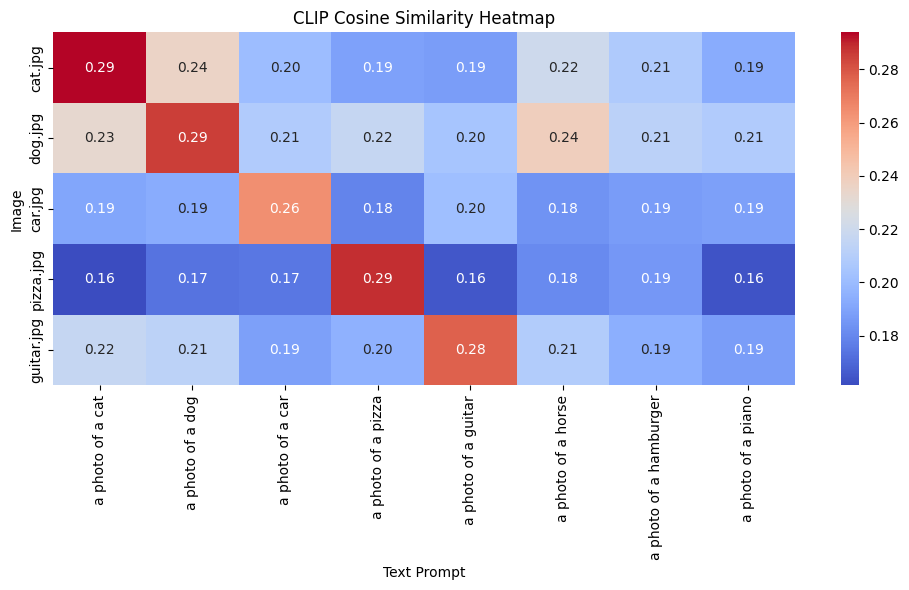

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 텍스트 & 이미지 라벨
labels = [
    "cat", "dog", "car", "pizza", "guitar"
]

# 2. similarity_matrix는 torch.Tensor → numpy로 변환
sim_matrix_np = similarity_matrix.cpu().numpy()

# 3. 히트맵 시각화
# 3. 히트맵 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(sim_matrix_np,
            xticklabels=text_prompts,
            yticklabels=image_filenames,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            cbar=True)

plt.xlabel("Text Prompt")
plt.ylabel("Image")
plt.title("CLIP Cosine Similarity Heatmap")
plt.tight_layout()
plt.show()

In [7]:
# 정답 인덱스 (앞의 5개 프롬프트가 정답쌍이라고 가정)
true_indices = torch.tensor([0, 1, 2, 3, 4]).to(device)

# Top-1 prediction
pred_indices = similarity_matrix.argmax(dim=1)

# Top-1 Accuracy
accuracy = (pred_indices == true_indices).float().mean().item()
print(f"\nTop-1 Accuracy: {accuracy * 100:.2f}%")



Top-1 Accuracy: 100.00%


In [10]:
# 각 이미지별로 유사도 높은 텍스트 상위 3개 인덱스 가져오기
top3_indices = similarity_matrix.topk(3, dim=1).indices

# Top-3 Accuracy 계산
top3_correct = torch.zeros(len(true_indices)).to(device)

for i in range(len(true_indices)):
    if true_indices[i] in top3_indices[i]:
        top3_correct[i] = 1.0

top3_accuracy = top3_correct.mean().item()
print(f"Top-3 Accuracy: {top3_accuracy * 100:.2f}%")

Top-3 Accuracy: 100.00%


#CLIP의 Cosine Similarity Heatmap 결과를 보고 정답쌍과 오답쌍의 유사도 차이가 어떻게 나타났는지 분석하시오. 또한 이러한 결과가 나타난 이유를 추론해보세요.


답: 정답쌍은 이미지와 그 내용에 맞는 텍스트 프롬프트 간의 쌍을 의미합니다. 히트맵을 보시면은 대각선 상에 위치하는 것을 알 수 있는데요, 0.29 정도의 빨간색으로 유사도가 높음을 알 수 있습니다. 이는 CLIP가 각 이미지와 관련성이 높은 텍스트를 성공적으로 찾아냄을 알 수 있습니다.

오답쌍은 이미지와 내용을 잘 못 설명해는 텍스트 프롬프트간의 쌍입니다. 대각선을 제외한 나머지 셀들인데요, 일반적으로 유사도가 낮은 것을 볼 수 있습니다. 여기서 조금 특이한 점은 고양이와 강아지 말이 모두 비슷하므로 유사도가 다른 오답쌍들에 비해서는 옾은 편입니다. 피자, 햄버거, 기타, 피아노도 마찬가지입니다.

이러한 결과가 나타난 이유는 CLIP의 학습방식과 관련이 있을 것 같습니다. CLIP은 수억 개의 텍스트나 이미지 데이터를 사용하여 학습됩니다. 올바른 것은 유사도를 높이고 잘못된 것은 유사도를 낮추는 것입니다. 대조 학습을 진행하면서 이미지의 특징과 텍스트의 의미 정보를 동일한 임베딩 공간에 매핑하는 방법을 학습합니다.

또한 공유 임베딩 공간이라 불리는 이미지와 텍스트를 같은 차원의 벡터 공간으로 인코딩 하는데요, 이 임베딩 차원에서는 의미론적으로 유사한 개념이 서로 가깝게 위치하게 됩니다. 코사인 유사도는 이 임베딩 차원에서 두 벡터간의 각도를 측정하므로 벡터가 가리키는 방향이 비슷할 수록 유사도가 높아질 것 같습니다.
